# Time Series

Dataset: https://www.kaggle.com/rakannimer/air-passengers

Links:
- https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
data = pd.read_csv("..\_datasets\AirPassengers.csv")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## set data as Time Series (ts)

In [3]:
ts = data.copy()
ts['Month'] = pd.to_datetime(ts['Month'])
ts = ts.set_index('Month')
print(ts.index)
ts

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot:xlabel='Month'>

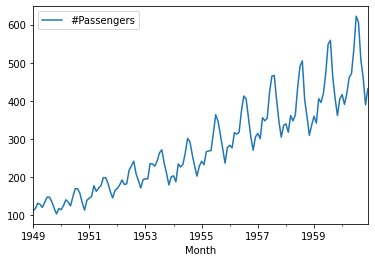

In [4]:
ts.plot(kind='line')

<AxesSubplot:xlabel='Month'>

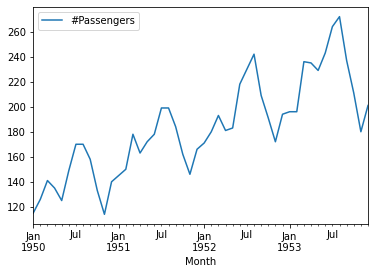

In [5]:
ts['1950':'1953'].plot(kind='line')

## STATIONARITY

This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. There are a lot of statistical theories to explore stationary series than non-stationary series. (Thus we can bring the fight to our home ground!)

- constant mean
- constant variance
- an auto co-variance that does not depend on time


[Dickey-Fuller Test](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/): This is one of the statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary (the force is strong with this one !!)

In [6]:
from statsmodels.tsa.stattools import adfuller

In [47]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    results = dict(zip(['Test Statistic','p-value','#Lags Used','Number of Observations Used'], dftest[:4]))
    results.update(dict((f"Critical value {k}",v) for k,v in dftest[4].items()))
    return results

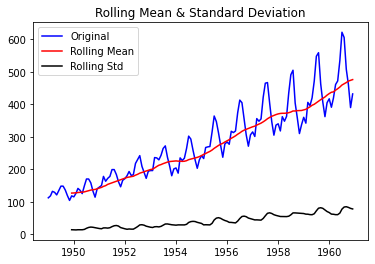

{'Test Statistic': 0.8153688792060482,
 'p-value': 0.991880243437641,
 '#Lags Used': 13,
 'Number of Observations Used': 130,
 'Critical value 1%': -3.4816817173418295,
 'Critical value 5%': -2.8840418343195267,
 'Critical value 10%': -2.578770059171598}

In [48]:
dftest = test_stationarity(ts['#Passengers'])
dftest

This is not stationary because :

- mean is increasing even though the std is small.
- Test stat is > critical value.
- Note: the signed values are compared and the absolute values.

## MAKING THE TIME SERIES STATIONARY

There are two major factors that make a time series non-stationary. They are:

- Trend: non-constant mean
- Seasonality: Variation at specific time-frames

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

Let’s start by working on the trend piece.

**Trend**

The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

In [56]:
ts_log = np.log(ts)
ts_log

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


<Figure size 1440x432 with 0 Axes>

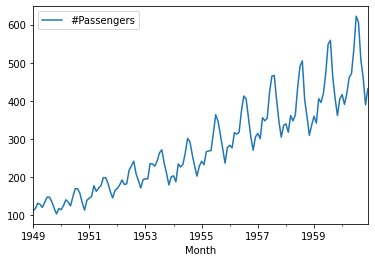

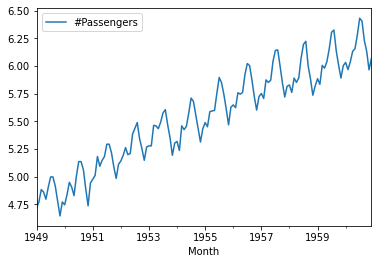

In [59]:
fig = plt.figure(figsize=(20,6))
ts.plot(kind="line")
ts_log.plot(kind="line")
plt.show()

<AxesSubplot:xlabel='Month'>

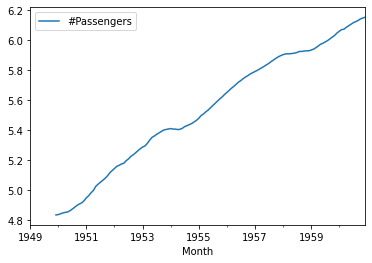

In [55]:
moving_avg = ts_log.rolling(window=12).mean()
moving_avg.plot(kind="line")